### Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '..')

In [3]:
import re
import torch
import pandas as pd
from tqdm import tqdm
from underthesea import word_tokenize
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from src.model.utils import load_file, save_file
from src.model.data import TextDataset
from src.model.model import BertClassifier
from src.model.train import train, test, plot_learning_curve

### Preparing dataset

In [4]:
df = pd.read_csv('../data/dataset.csv')

In [5]:
df.head()

,Unnamed: 0,partner_id,specialist_id,status,gender,province_id,age,reason_combind,specialist_name
0,0,2,22,2,NaN,1,38,khám tiêu hóa,tiêu hoá
1,1,2,1,2,NaN,1,29,"đau lưng nhiều,ngồi lâu cứng lưng",cơ xương khớp
2,2,4,3,2,NaN,40,29,"hở van tim 3 lá,ngoại tâm thu",tim mạch
3,3,17,3,2,NaN,10,40,"đau tức ngực bên trái,cảm giác hồi hộp",tim mạch
4,4,17,3,2,NaN,-1,70,cao huyết áp,tim mạch


In [6]:
df.specialist_name.unique()

array(['tiêu hoá', 'cơ xương khớp', 'tim mạch', 'thần kinh',
       'tai mũi họng', 'nhi khoa', 'sản phụ khoa', 'nội khoa', 'ung bướu',
       'nam học', 'da liễu', 'sức khỏe tâm thần', 'bệnh viêm gan',
       'chuyên khoa mắt', 'thận - tiết niệu', 'tiểu đường - nội tiết',
       'hô hấp - phổi', 'vô sinh - hiếm muộn'], dtype=object)

In [7]:
# Merge 'chuyên khoa cột sống' to 'cơ xương khớp'
df['specialist_name'] = df['specialist_name'].replace('cột sống', 'cơ xương khớp')

# Verify the changes
print("Updated specialist names:")
print(df.specialist_name.unique())

Updated specialist names:
['tiêu hoá' 'cơ xương khớp' 'tim mạch' 'thần kinh' 'tai mũi họng'
 'nhi khoa' 'sản phụ khoa' 'nội khoa' 'ung bướu' 'nam học' 'da liễu'
 'sức khỏe tâm thần' 'bệnh viêm gan' 'chuyên khoa mắt' 'thận - tiết niệu'
 'tiểu đường - nội tiết' 'hô hấp - phổi' 'vô sinh - hiếm muộn']


In [8]:
# Merge 'khám tổng quát' to 'nội khoa'
df['specialist_name'] = df['specialist_name'].replace('khám tổng quát', 'nội khoa')

# Verify the changes
print("Updated specialist names after merging 'khám tổng quát' to 'nội khoa':")
print(df.specialist_name.unique())

Updated specialist names after merging 'khám tổng quát' to 'nội khoa':
['tiêu hoá' 'cơ xương khớp' 'tim mạch' 'thần kinh' 'tai mũi họng'
 'nhi khoa' 'sản phụ khoa' 'nội khoa' 'ung bướu' 'nam học' 'da liễu'
 'sức khỏe tâm thần' 'bệnh viêm gan' 'chuyên khoa mắt' 'thận - tiết niệu'
 'tiểu đường - nội tiết' 'hô hấp - phổi' 'vô sinh - hiếm muộn']


In [9]:
# Drop rows with NaN values
df = df.dropna().reset_index(drop=True)

# Verify the result
print(f"Dataset shape after dropping NaN values: {df.shape}")
print(f"Number of NaN values remaining: {df.isna().sum().sum()}")

Dataset shape after dropping NaN values: (45790, 9)
Number of NaN values remaining: 0


In [10]:
df

,Unnamed: 0,partner_id,specialist_id,status,gender,province_id,age,reason_combind,specialist_name
0,147,2,1,2,1.0,1,33,đau tay phải,cơ xương khớp
1,925,8,22,2,0.0,34,32,"có kl viêm đại trực tràng, viêm hang vị",tiêu hoá
2,952,3,18,2,0.0,31,47,tê bì một bên môi và dưới cằm,thần kinh
3,1072,4,18,2,1.0,1,59,có cảm giác kim châm dưới da,thần kinh
4,1111,8,22,2,0.0,25,29,"đau quặn bụng quanh rốn, đau tức hậu môn, đi p...",tiêu hoá
...,...,...,...,...,...,...,...,...,...
45785,50162,111,17,2,0.0,74,0,bệnh nhiều thứ . nên đi làm tổng quát,nội khoa
45786,50163,125,1,2,0.0,74,0,"đau khớp vai, cử động tay phải nghe lụp cụp",cơ xương khớp
45787,50164,410,26,2,0.0,82,0,bìu có nỗi mụt,nam học
45788,50165,414,1,2,1.0,1,0,"trượt chân, ngã ngồi đau khu xương cụt",cơ xương khớp


In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(df['specialist_name'])
labels = label_encoder.transform(df['specialist_name'])

In [12]:
save_file('../models/bert/labels.pkl', labels)
save_file('../models/bert/label_encoder.pkl', label_encoder)

In [13]:
input_text = df['reason_combind']

In [14]:
# Function to remove punctuation except apostrophe and Vietnamese diacritical marks
def clean_text(text):
    if isinstance(text, str):
        # Keep Vietnamese characters, letters, numbers, spaces, apostrophes
        # Don't remove diacritical marks like: à, á, â, ã, è, é, ê, ì, í, ò, ó, ô, õ, ù, ú, ý, ă, đ, ĩ, ũ, ơ, ư, ạ, ả, ấ, ầ, ẩ, ẫ, ậ, ắ, ằ, ẳ, ẵ, ặ, ẹ, ẻ, ẽ, ế, ề, ể, ễ, ệ, ỉ, ị, ọ, ỏ, ố, ồ, ổ, ỗ, ộ, ớ, ờ, ở, ỡ, ợ, ụ, ủ, ứ, ừ, ử, ữ, ự, ỳ, ỵ, ỷ, ỹ
        # Remove other punctuation like: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~
        text = re.sub(r'[^\w\s\'\u00C0-\u1EF9]', ' ', text)
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply the cleaning function to the input text
input_text = input_text.apply(clean_text)
print("Text cleaned of punctuation except apostrophes and Vietnamese diacritical marks")
print(input_text.iloc[0])

Text cleaned of punctuation except apostrophes and Vietnamese diacritical marks
đau tay phải


In [15]:
input_text

0                                            đau tay phải
1                   có kl viêm đại trực tràng viêm hang vị
2                            tê bì một bên môi và dưới cằm
3                             có cảm giác kim châm dưới da
4        đau quặn bụng quanh rốn đau tức hậu môn đi phâ...
                               ...                        
45785                  bệnh nhiều thứ nên đi làm tổng quát
45786           đau khớp vai cử động tay phải nghe lụp cụp
45787                                       bìu có nỗi mụt
45788                trượt chân ngã ngồi đau khu xương cụt
45789                                   cấy que tranh thai
Name: reason_combind, Length: 45790, dtype: object

In [16]:
# Remove more than one consecutive instance of the letter 'x'
def remove_consecutive_x(text):
    if isinstance(text, str):
        # Replace multiple consecutive 'x' or 'X' with a single 'x' or 'X'
        text = re.sub(r'[xX]{2,}', lambda m: m.group(0)[0], text)
        return text
    return ""

# Apply the function to the input text
input_text = input_text.apply(remove_consecutive_x)
print("Text with consecutive 'x' characters removed:")
print(input_text.iloc[0])

Text with consecutive 'x' characters removed:
đau tay phải


In [17]:
# Replace multiple spaces with a single space
def clean_spaces(text):
    if isinstance(text, str):
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply the cleaning function to the input text
input_text = input_text.apply(clean_spaces)
print("Text with multiple spaces cleaned:")
print(input_text.iloc[0])

Text with multiple spaces cleaned:
đau tay phải


In [18]:
# Apply word tokenization to each text in the dataset
def tokenize_text(text):
    if isinstance(text, str):
        # Apply underthesea word tokenization with format="text"
        # Example output: 'Chàng_trai 9X Quảng_Trị khởi_nghiệp từ nấm sò'
        tokenized = word_tokenize(text, format="text")
        return tokenized
    return ""

# Apply the tokenization function to the input text
input_text = input_text.apply(tokenize_text)
print("Text after word tokenization:")
print(input_text.iloc[0])

Text after word tokenization:
đau tay_phải


In [19]:
len(input_text)

45790

In [20]:
tokenizer = AutoTokenizer.from_pretrained("../models/bert")

In [21]:
tokens = [
    tokenizer(
        i, padding='max_length', max_length=256,
        truncation=True, return_tensors="pt"
    )
    for i in tqdm(input_text)
]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45790/45790 [00:17<00:00, 2569.91it/s]


In [22]:
save_file('../data/training/tokens.pkl', tokens)

### Training

In [23]:
tokens = load_file('../data/training/tokens.pkl')
labels = load_file('../models/bert/labels.pkl')

In [24]:
label_encoder = load_file('../models/bert/label_encoder.pkl')
num_classes = len(label_encoder.classes_)

In [25]:
num_classes

18

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    tokens, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [27]:
train_dataset = TextDataset(X_train, y_train)
valid_dataset = TextDataset(X_valid, y_valid)
test_dataset = TextDataset(X_test, y_test)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
device

device(type='cuda', index=0)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [31]:
model = BertClassifier(
    model_name='../models/bert',
    dropout=0.3,
    num_classes=num_classes
)

In [32]:
model

BertClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay

In [33]:
# Calculate and display model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

Total parameters: 135,401,234
Trainable parameters: 402,962
Non-trainable parameters: 134,998,272
Percentage of trainable parameters: 0.30%


In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

if torch.cuda.is_available():
    model = model.to(device)
    criterion = criterion.to(device)

In [35]:
train_losses, valid_losses = train(
    train_loader,
    valid_loader,
    model,
    criterion,
    optimizer,
    device,
    num_epochs=2,
    model_path='../models/trained/trained.pth'
)

Epoch 1 of 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [07:32<00:00,  1.58s/it]


Train loss: 2.384920155668592, Validation Loss: 2.204160102568437
Best Validation Loss: 2.204160102568437
Epoch 2 of 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [07:33<00:00,  1.58s/it]

Train loss: 2.3051232357958815, Validation Loss: 2.230566592166648
Best Validation Loss: 2.204160102568437


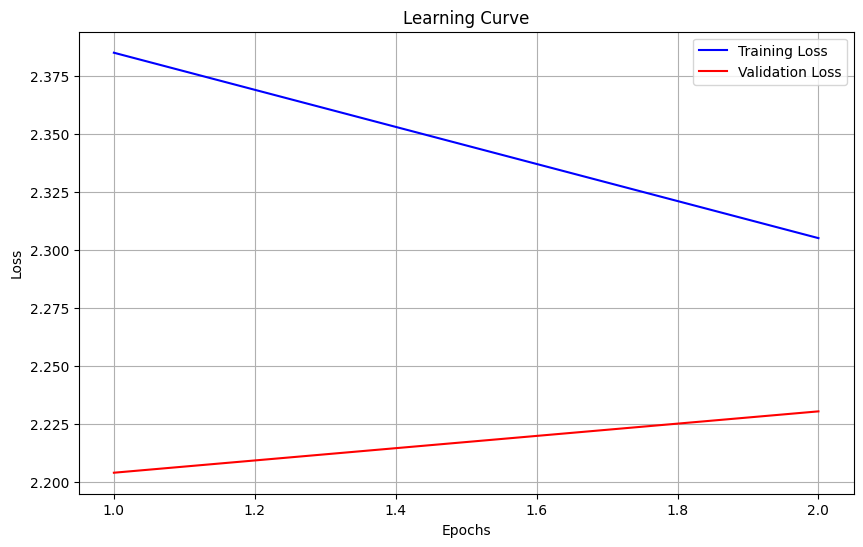

In [36]:
plot_learning_curve(
    train_losses,
    valid_losses,
)

In [37]:
test(
    test_loader,
    model,
    criterion,
    device
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [07:33<00:00,  1.58s/it]

Test Loss: 2.2362137006965663, Test Accuracy: 0.31765389082462253


In [38]:
test(
    valid_loader,
    model, 
    criterion,
    device
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [07:33<00:00,  1.58s/it]

Test Loss: 2.230566592166648, Test Accuracy: 0.3164561556329849
